In [1]:
%reload_ext watermark
%matplotlib inline

import os
from metapool.metapool import *
from metapool import validate_and_scrub_sample_sheet, make_sample_sheet
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2021-11-10T18:59:42.357984-08:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

metapool    : 0+untagged.99.gc617499
sample_sheet: 0.12.0
openpyxl    : 3.0.9

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 3.10.0-957.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: jupyter2

numpy     : 1.20.3
seaborn   : 0.11.2
pandas    : 1.3.3
matplotlib: 3.3.4
re        : 2.2.1



### Here's how it should work.

1. Start with a **basic plate map** (links each sample to it's approprite row and column)
2. Add the output of the MiniPico assay of sample DNA concentrations. 
    - Enables you to automatically make a **normalization pick list** for starting the shotgun library prep itself. 
3. Outputs visualizations of these concentrations on the plate.
    - This allows you to double check the plate map and DNA concentration read.

**Code from Knight Lab shotgun pipeline notebook**

## Step 1: read in plate map

**Enter the correct path to the plate map file**. This will serve as the plate map for relating all subsequent information.

In [2]:
plate_map_fp = 'Mouse_FMT_Plate_9+Healthy_Aging_1-2+PSQ_CEN_PE_Fecal - Map.tsv'

if not os.path.isfile(plate_map_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the plate map**. It should look something like this:

```
Sample	Row	Col	Blank
GLY_01_012	A	1	False
GLY_14_034	B	1	False
GLY_11_007	C	1	False
GLY_28_018	D	1	False
GLY_25_003	E	1	False
GLY_06_106	F	1	False
GLY_07_011	G	1	False
GLY_18_043	H	1	False
GLY_28_004	I	1	False
```

In [3]:
plate_df = read_plate_map_csv(open(plate_map_fp,'r'))

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well
0,0363235686,A,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",A1
1,0363237561,C,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",C1
2,0363237575,E,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",E1
3,0363237330,G,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",G1
4,0363235711,I,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",I1


## Check for duplicate sample IDs

This messes things up downstream. Make sure each sample has a different name.

In [4]:
try:
    assert(len(set(plate_df['Sample'])) == len(plate_df['Sample']))
except AssertionError as e:
    prev = ''
    for sample in sorted(plate_df['Sample']):
        if sample == prev:
            print('\nDuplicates:')
            print(plate_df.loc[plate_df['Sample'] == prev,])
            print(plate_df.loc[plate_df['Sample'] == prev,])
        
        prev = sample
    print('\n\nWarning! Some samples names are duplicate! Please update plate map to fix duplciates')
    raise e

## Step 2: read in DNA concentrations and add to plate map

**Enter the correct path to the Pico DNA concentration output**. This should be a csv-formatted file produced by the MiniPico assay on the condensed, 384-well plate. 

In [5]:
sample_concs_fp = 'Mouse_FMT_Seals_Plat_9+Healthy_Aging_1-2+PSQ_CEN_PE_Fecal - gDNA quant.txt'

if not os.path.isfile(sample_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the DNA concentration output file**. It should look something like this:
    
```
Results

Well ID	Well	[Blanked-RFU]	[Concentration]
SPL1	A1	5243.000	3.432
SPL2	C1	4949.000	3.239
SPL3	E1	15302.000	10.016
SPL4	G1	4039.000	2.644
SPL5	I1	12862.000	8.419
SPL6	K1	2840.000	1.859
SPL7	M1	3343.000	2.188
```

In [6]:
sample_concs = read_pico_csv(sample_concs_fp, sep='\t', plate_reader='SpectraMax_i3x')

plate_df = pd.merge(plate_df, sample_concs, on='Well')

well_col = 'Well'

plate_df.head()

,Sample,Row,Col,Blank,Project Plate,Project Name,Compressed Plate Name,Well,Sample DNA Concentration
0,0363235686,A,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",A1,2.918
1,0363237561,C,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",C1,11.012
2,0363237575,E,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",E1,7.956
3,0363237330,G,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",G1,7.929
4,0363235711,I,1,False,Mouse_FMT_Seals_13309_P9,Mouse_FMT_Seals_13309,"Mixed_project_plates,9,1,2,1",I1,2.137


**Visualize plate DNA concentrations and plate map:**

/opt/meta_pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


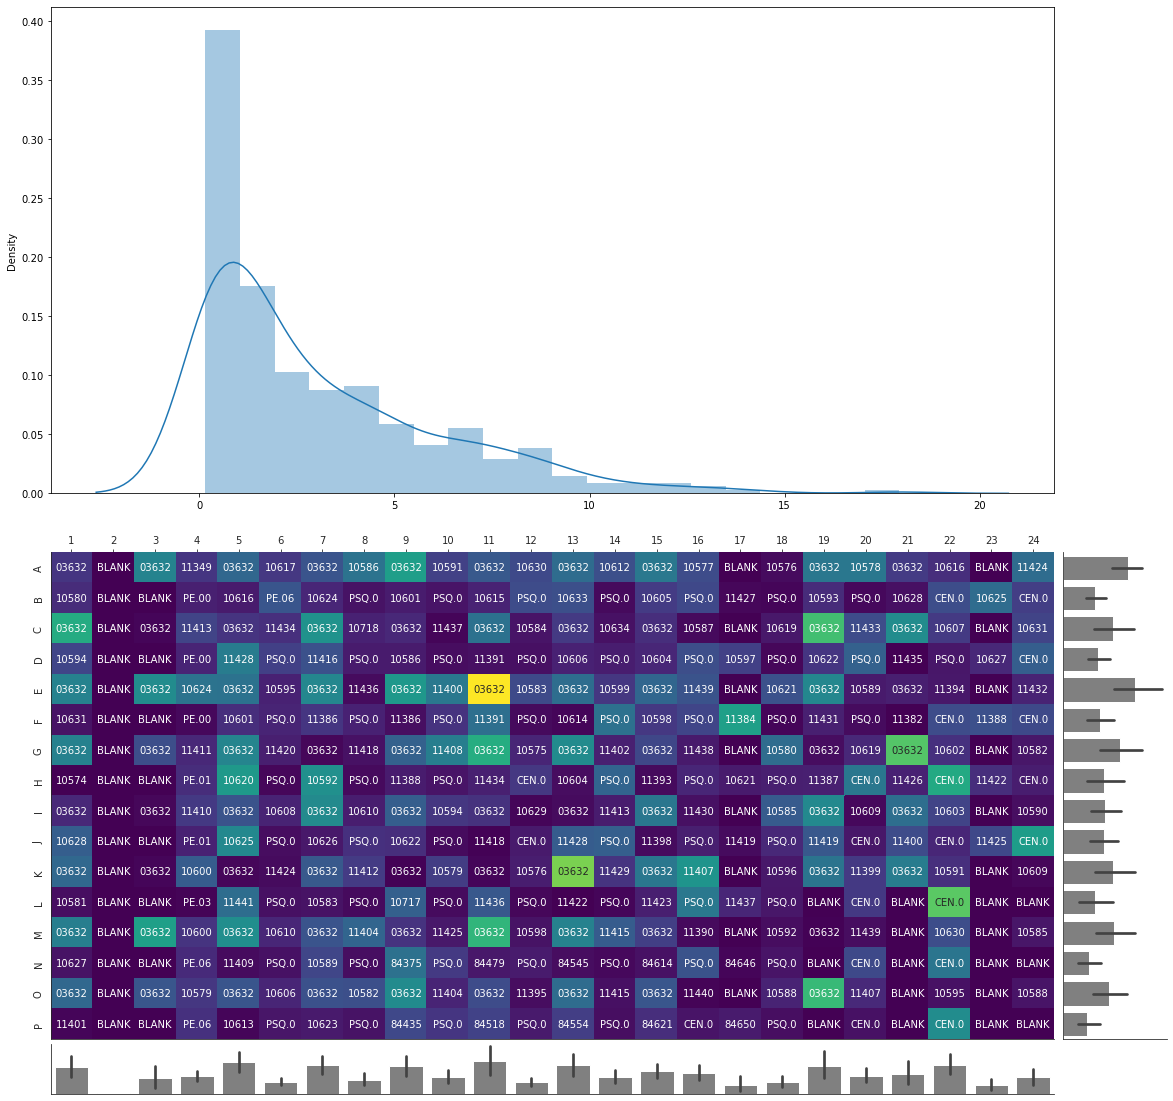

In [7]:
# get DNA concentratin information
dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col=well_col)

clip = np.clip(dna_concs, 0, 30)
plot_plate_vals(clip,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')

In [8]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### gDNA concentration heatmap, Plate 1

/opt/meta_pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


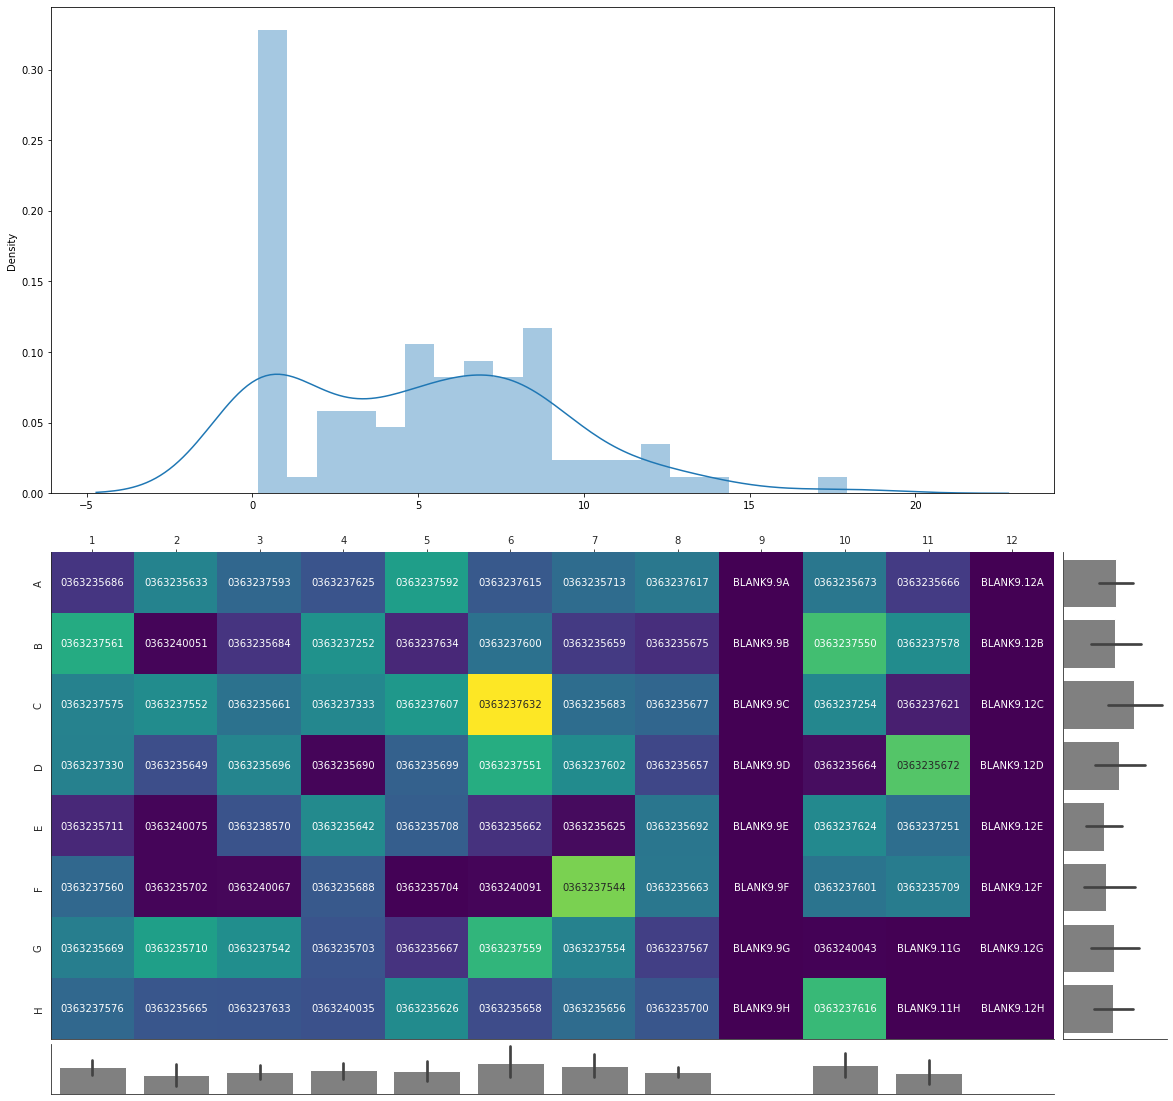

In [9]:
plot_plate_vals(dna_concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 2

/opt/meta_pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


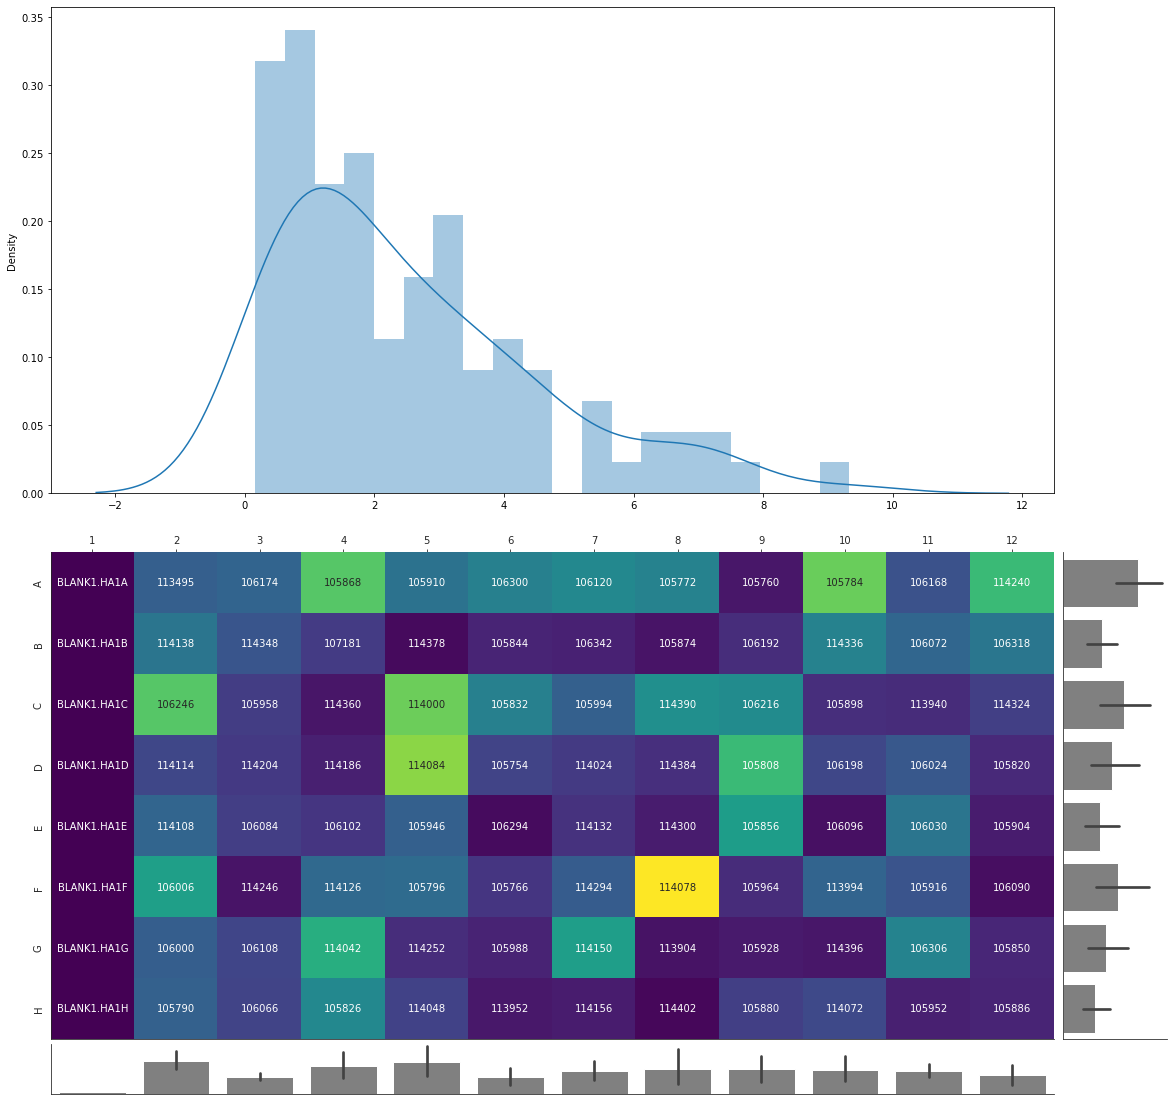

In [10]:
plot_plate_vals(dna_concs[np.ix_(even_rows,odd_cols)],
                annot_str=names[np.ix_(even_rows,odd_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 3

/opt/meta_pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


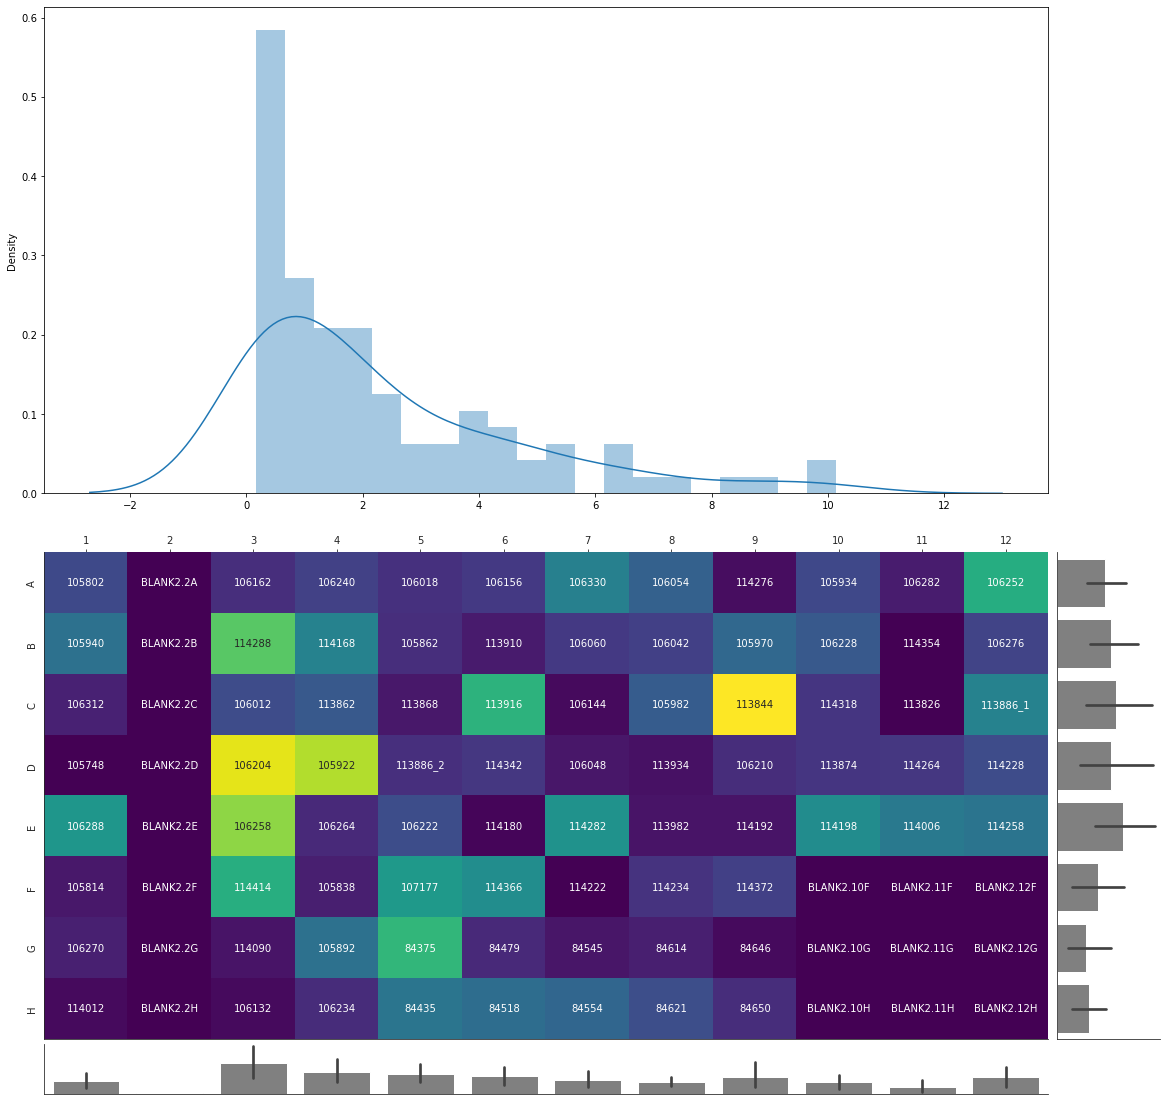

In [11]:
plot_plate_vals(dna_concs[np.ix_(odd_rows, even_cols)],
                annot_str=names[np.ix_(odd_rows, even_cols)],
                color_map='viridis',
                annot_fmt='')

### gDNA concentration heatmap, Plate 4

/opt/meta_pooling_nb/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


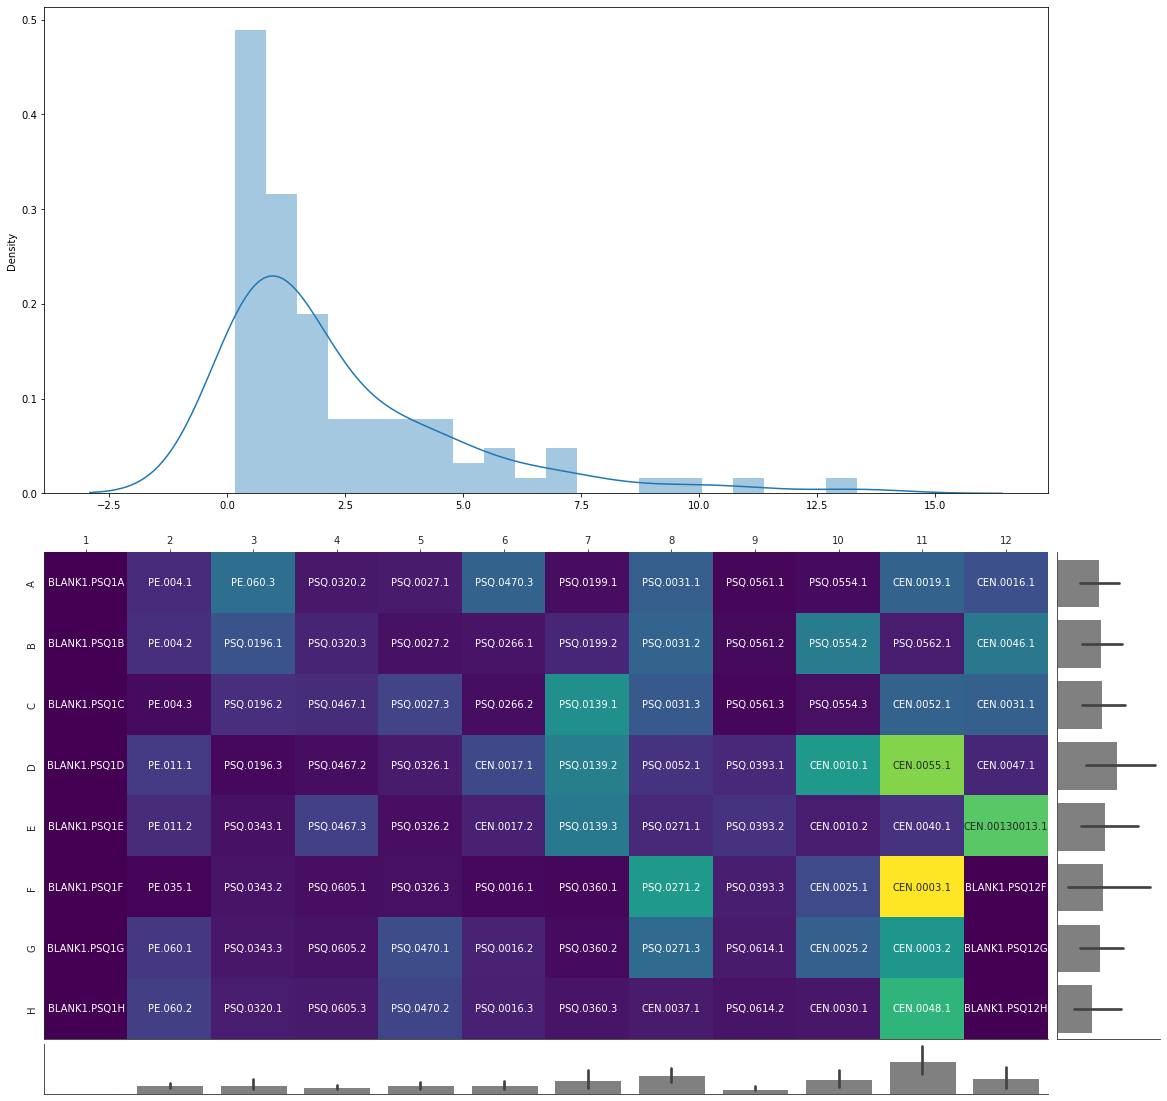

In [12]:
plot_plate_vals(dna_concs[np.ix_(odd_rows, odd_cols)],
                annot_str=names[np.ix_(odd_rows, odd_cols)],
                color_map='viridis',
                annot_fmt='')